In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/Thesis1/Done

/content/drive/MyDrive/Thesis1/Done


# Multi template matching

## Load and resize image

In [ ]:
from imutils.object_detection import non_max_suppression
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread("/content/drive/MyDrive/Thesis1/Done/khanh5.jpg")

image = cv2.resize(image, (2255, 3151))
print("Image shape:", image.shape)

Image shape: (3151, 2255, 3)


## Load templates

In [ ]:
tmplt1 = cv2.imread("/content/drive/MyDrive/Thesis1/Done/large_corner_v6.png")
tmplt2 = cv2.imread("/content/drive/MyDrive/Thesis1/Done/small_corner_v8.png")
print(tmplt1.shape)
print(tmplt2.shape)
h1, w1 = tmplt1.shape[:2]
h2, w2 = tmplt2.shape[:2]

(93, 96, 3)
(68, 58, 3)


## Template Matching

In [ ]:
result1 = cv2.matchTemplate(image, tmplt1, cv2.TM_SQDIFF)
result2 = cv2.matchTemplate(image, tmplt2, cv2.TM_SQDIFF)

## Define thresholds and find matches

In [ ]:
threshold1 = 200000000
threshold2 = 28000000

(y1, x1) = np.where(result1 <= threshold1)
(y2, x2) = np.where(result2 <= threshold2)

## Draw Bounding Boxes Before NMS

In [ ]:
clone = image.copy()

In [ ]:
count1 = 0
for (x, y) in zip(x1, y1):
	count1 += 1
	# vẽ bounding boxes
	# (x,y) là tọa độ góc trên trái; (x+w1, y+h1) là tọa độ góc dưới phải
	# Độ dày 3 pixel
	cv2.rectangle(clone, (x, y), (x + w1, y + h1), (0, 255, 0), 3)

count2 = 0
for (x, y) in zip(x2, y2):
	count2 += 1
	cv2.rectangle(clone, (x, y), (x + w2, y + h2), (255, 0, 0), 3)

In [ ]:
cv2_imshow(clone)

Output hidden; open in https://colab.research.google.com to view.

## Non-Maximum suppression

In [ ]:
rects_1 = []

for (x, y) in zip(x1, y1):
	rects_1.append((x, y, x + w1, y + h1))

pick_1 = non_max_suppression(np.array(rects_1), overlapThresh=0.5)
print("{} matched locations after NMS".format(len(pick_1)))

for (startX, startY, endX, endY) in pick_1:
	cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 3)

8 matched locations after NMS


In [ ]:
rects_2 = []

for (x, y) in zip(x2, y2):
	rects_2.append((x, y, x + w2, y + h2))

pick_2 = non_max_suppression(np.array(rects_2), overlapThresh=0.5)
print("{} matched locations after NMS".format(len(pick_2)))

for (startX, startY, endX, endY) in pick_2:
	cv2.rectangle(image, (startX, startY), (endX, endY), (255, 0, 0), 3)

23 matched locations after NMS


## Display result

In [ ]:
cv2_imshow(image)

Output hidden; open in https://colab.research.google.com to view.

# Load pretrained model and predict

## Xác định vị trí các bounding box lớn và nhỏ

### Khởi tạo ma trận boungding boxes

In [ ]:
# large_contours_matrix và small_contours_matrix chứa các tọa độ của các bounding boxes
# sau khi đã áp dụng NMS cho các template lớn và nhỏ
large_matrix = np.array(pick_1)
small_matrix = np.array(pick_2)

copy_large_matrix = large_matrix.copy()

### Sắp xếp và chọn 3 bounding boxes ở trên cùng

In [ ]:
# Sắp xếp ma trận theo cột thứ hai từ bé đến lớn
large_matrix = large_matrix[large_matrix[:,1].argsort()]
# Lấy 3 cái đầu tiên, tương ứng với 3 ô vuông trên cùng
top_matrix = large_matrix[:3]
# Sắp xếp theo cột đầu tiên từ bé đến lớn
top_matrix = top_matrix[top_matrix[:,0].argsort()]

top_left = top_matrix[0]
top_middle = top_matrix[1]
top_right = top_matrix[2]

### Tìm và xóa 3 bounding boxes ở trên cùng

In [ ]:
top_left_index = np.where((copy_large_matrix == top_left).all(axis=1))[0][0]
top_middle_index = np.where((copy_large_matrix == top_middle).all(axis=1))[0][0]
top_right_index = np.where((copy_large_matrix == top_right).all(axis=1))[0][0]

In [ ]:
print("top_left_index: ",top_left_index)
print("top_middle_index: ",top_middle_index)
print("top_right_index: ",top_right_index)

top_left_index:  7
top_middle_index:  5
top_right_index:  6


In [ ]:
copy_large_matrix = np.delete(copy_large_matrix, [top_left_index, top_middle_index, top_right_index], axis=0)

### Chọn và xóa 2 bounding boxes ở dưới cùng

In [ ]:
# Lấy 2 hàng cuối cùng, do lúc nãy đã sắp xếp theo y nên nó ứng với các ô dưới cùng
bot_matrix = large_matrix[-2:]
# Sắp xếp theo x
bot_matrix = bot_matrix[bot_matrix[:,0].argsort()]

bot_left = bot_matrix[0]
bot_right= bot_matrix[1]

bot_left_index = np.where((copy_large_matrix == bot_left).all(axis=1))[0][0]
bot_right_index = np.where((copy_large_matrix == bot_right).all(axis=1))[0][0]

copy_large_matrix = np.delete(copy_large_matrix, [bot_left_index, bot_right_index], axis=0)

### Chọn và xóa 2 bounding boxes trái phải ở giữa

In [ ]:
# Sắp xếp theo x
left_matrix = large_matrix[large_matrix[:,0].argsort()]
# Lấy 3 hàng đầu tiên
_left_matrix = left_matrix[:3]
# Sắp xếp theo y
_left_matrix = _left_matrix[_left_matrix[:,1].argsort()]
# Ô vuông giữa bên trái
middle_left = _left_matrix[1]
# Lấy 3 hàng cuối
_right_matrix = left_matrix[-3:]
# Sắp xếp theo y
_right_matrix = _right_matrix[_right_matrix[:,1].argsort()]
# Ô vuông giữa bên phải
middle_right = _right_matrix[1]

middle_left_index = np.where((copy_large_matrix == middle_left).all(axis=1))[0][0]
middle_right_index = np.where((copy_large_matrix == middle_right).all(axis=1))[0][0]

copy_large_matrix = np.delete(copy_large_matrix, [middle_left_index, middle_right_index], axis=0)

### Giữ lại bounding boxes ở giữa

In [ ]:
copy_large_matrix

array([[1564,  974, 1660, 1067]])

In [ ]:
midle_midle = copy_large_matrix[0]
print(midle_midle)

[1564  974 1660 1067]


### Chọn và phân loại các bounding boxes nhỏ

In [ ]:
small_matrix

array([[ 559, 2850,  617, 2918],
       [ 844, 2847,  902, 2915],
       [1131, 2845, 1189, 2913],
       [1416, 2843, 1474, 2911],
       [1697, 2843, 1755, 2911],
       [ 562, 2047,  620, 2115],
       [ 847, 2046,  905, 2114],
       [1692, 2044, 1750, 2112],
       [1412, 2043, 1470, 2111],
       [ 688, 2009,  746, 2077],
       [1570, 2007, 1628, 2075],
       [1133, 2007, 1191, 2075],
       [1570, 1703, 1628, 1771],
       [1133, 1702, 1191, 1770],
       [ 689, 1702,  747, 1770],
       [1570, 1630, 1628, 1698],
       [1133, 1629, 1191, 1697],
       [ 688, 1628,  746, 1696],
       [1572, 1111, 1630, 1179],
       [1133, 1109, 1191, 1177],
       [ 687, 1105,  745, 1173],
       [1887,  926, 1945,  994],
       [1889,  636, 1947,  704]])

In [ ]:
for small in small_matrix:
  print(small, "\n")
  print(small[0])
  print(small[1])

[ 559 2850  617 2918] 

559
2850
[ 844 2847  902 2915] 

844
2847
[1131 2845 1189 2913] 

1131
2845
[1416 2843 1474 2911] 

1416
2843
[1697 2843 1755 2911] 

1697
2843
[ 562 2047  620 2115] 

562
2047
[ 847 2046  905 2114] 

847
2046
[1692 2044 1750 2112] 

1692
2044
[1412 2043 1470 2111] 

1412
2043
[ 688 2009  746 2077] 

688
2009
[1570 2007 1628 2075] 

1570
2007
[1133 2007 1191 2075] 

1133
2007
[1570 1703 1628 1771] 

1570
1703
[1133 1702 1191 1770] 

1133
1702
[ 689 1702  747 1770] 

689
1702
[1570 1630 1628 1698] 

1570
1630
[1133 1629 1191 1697] 

1133
1629
[ 688 1628  746 1696] 

688
1628
[1572 1111 1630 1179] 

1572
1111
[1133 1109 1191 1177] 

1133
1109
[ 687 1105  745 1173] 

687
1105
[1887  926 1945  994] 

1887
926
[1889  636 1947  704] 

1889
636


In [ ]:
SBD = []
multiple_choice_small = []
for small in small_matrix:
    if (small[0] > top_middle[0] and small[0] < top_right[0] and
        small[1] > top_middle[1] and small[1] < midle_midle[1]):
        SBD.append(small)
    else:
        multiple_choice_small.append(small)

In [ ]:
# Trong 2 ô, sắp xếp theo trục y
SBD_top = SBD[np.argmin(SBD, axis=0)[1]]
SBD_bot = SBD[np.argmax(SBD, axis=0)[1]]

In [ ]:
multiple_choice_small = np.array(multiple_choice_small)
# Sắp xếp theo y
multiple_choice_small = multiple_choice_small[multiple_choice_small[:,1].argsort()]

multiple_choice_small_copy = multiple_choice_small.copy()
# Lấy 3 hàng đầu tiên
top_1_multiple_choise_small = multiple_choice_small[:3]
# Sắp xếp theo x
top_1_multiple_choise_small = top_1_multiple_choise_small[top_1_multiple_choise_small[:,0].argsort()]
# Lấy 3 hàng tiếp theo
top_2_multiple_choise_small = multiple_choice_small[3:6]
top_2_multiple_choise_small = top_2_multiple_choise_small[top_2_multiple_choise_small[:,0].argsort()]
# Lấy 3 hàng tiếp theo
top_3_multiple_choise_small = multiple_choice_small[6:9]
top_3_multiple_choise_small = top_3_multiple_choise_small[top_3_multiple_choise_small[:,0].argsort()]
# Lấy 3 hàng tiếp theo
top_4_multiple_choise_small = multiple_choice_small[9:12]
top_4_multiple_choise_small = top_4_multiple_choise_small[top_4_multiple_choise_small[:,0].argsort()]
# Lấy 4 hàng tiếp theo
top_5_multiple_choise_small = multiple_choice_small[12:16]
top_5_multiple_choise_small = top_5_multiple_choise_small[top_5_multiple_choise_small[:,0].argsort()]
# Lấy 5 hàng còn lại
top_6_multiple_choise_small = multiple_choice_small[16:21]
top_6_multiple_choise_small = top_6_multiple_choise_small[top_6_multiple_choise_small[:,0].argsort()]

In [ ]:
top_1_left_multiple_choice_small = top_1_multiple_choise_small[0]
top_1_middle_multiple_choice_small = top_1_multiple_choise_small[1]
top_1_right_multiple_choice_small = top_1_multiple_choise_small[2]

top_2_left_multiple_choice_small = top_2_multiple_choise_small[0]
top_2_middle_multiple_choice_small = top_2_multiple_choise_small[1]
top_2_right_multiple_choice_small = top_2_multiple_choise_small[2]

top_3_left_multiple_choice_small = top_3_multiple_choise_small[0]
top_3_middle_multiple_choice_small = top_3_multiple_choise_small[1]
top_3_right_multiple_choice_small = top_3_multiple_choise_small[2]

top_4_left_multiple_choice_small = top_4_multiple_choise_small[0]
top_4_middle_multiple_choice_small = top_4_multiple_choise_small[1]
top_4_right_multiple_choice_small = top_4_multiple_choise_small[2]

top_5_1_multiple_choice_small = top_5_multiple_choise_small[0]
top_5_2_multiple_choice_small = top_5_multiple_choise_small[1]
top_5_3_multiple_choice_small = top_5_multiple_choise_small[2]
top_5_4_multiple_choice_small = top_5_multiple_choise_small[3]

top_6_1_multiple_choice_small = top_6_multiple_choise_small[0]
top_6_2_multiple_choice_small = top_6_multiple_choise_small[1]
top_6_3_multiple_choice_small = top_6_multiple_choise_small[2]
top_6_4_multiple_choice_small = top_6_multiple_choise_small[3]
top_6_5_multiple_choice_small = top_6_multiple_choise_small[4]

## Chia ảnh thành 2 phần info và assignment

In [ ]:
image = cv2.imread("/content/drive/MyDrive/Thesis1/Done/khanh5.jpg")

image = cv2.resize(image, (2255, 3151))

### Info

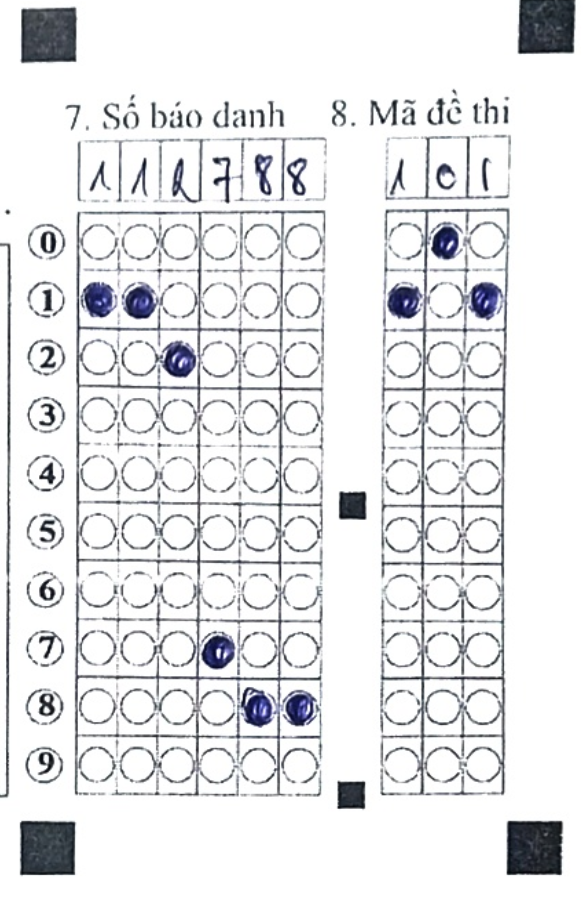

In [ ]:
info_part = image[top_middle[1]: middle_right[3], top_middle[0]:middle_right[2]]
cv2_imshow(info_part)

### assignment

In [ ]:
assignment_part = image[middle_left[3]: bot_right[3], middle_left[2]:bot_right[0]]
cv2_imshow(assignment_part)

Output hidden; open in https://colab.research.google.com to view.

## Load pretrained model yolo-nas

In [ ]:
!pip install super-gradients==3.7.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 28.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 85.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup

In [ ]:
from super_gradients.training import models

The console stream is logged into /root/sg_logs/console.log


[2024-07-02 01:44:31] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-07-02 01:44:51] INFO - utils.py - NumExpr defaulting to 2 threads.
[2024-07-02 01:44:55] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2024-07-02 01:44:55] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2024-07-02 01:44:55] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2024-07-02 01:44:55] WARNING - env_sanity_check.py - Failed to verify installed packages: sphinx-rtd-theme required but not found
[2024-07-02 01:44:55] WARNING - env_sanity_check.py - Failed to verify installed packages: torchmetrics required but not found
[2024-07-02 01:44:55] WARNING - env_sanity_check.py - Failed to verify installed packages: hydra-core required but not found
[2024-07-02 01:44:55] WARNI

### info

In [ ]:
MODEL_ARCH = 'yolo_nas_s'
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
info_model = models.get(
    MODEL_ARCH,
    num_classes=2,
    checkpoint_path=f"/content/drive/MyDrive/Thesis1/Done/model/info/checkpoints/RUN_20240617_011140_949735/average_model.pth"
).to(DEVICE)

[2024-07-02 01:45:08] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/Thesis1/Done/model/info/checkpoints/RUN_20240617_011140_949735/average_model.pth checkpoint.


In [ ]:
# Đặt ngưỡng tối thiểu cho dự đoán
CONFIDENCE_THRESHOLD = 0.5
result = info_model.predict(info_part, conf=CONFIDENCE_THRESHOLD, max_predictions=100)
# Tọa độ bounding box của dự đoán
boxes = result.prediction.bboxes_xyxy
# Độ tự tin
confidences = result.prediction.confidence
# Chuyển kết quả dự đoán về ID: 0 or 1
class_ids = result.prediction.labels.astype(int)
colors = [(0, 0, 255), (255, 0, 0)]
for (bbox, cls_id) in zip(boxes, class_ids):
    color = colors[cls_id]
    cv2.rectangle(info_part, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 2)

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[2024-07-02 01:45:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


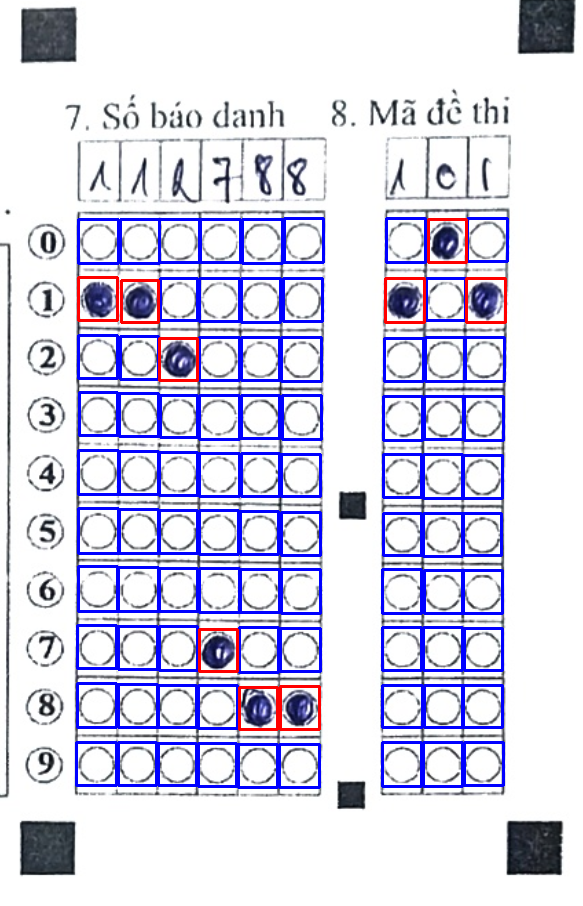

In [ ]:
cv2_imshow(info_part)

### assignment

In [ ]:
MODEL_ARCH = 'yolo_nas_s'
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
assignment_model = models.get(
    MODEL_ARCH,
    num_classes=2,
    checkpoint_path=f"/content/drive/MyDrive/Thesis1/Done/model/assignment/checkpoints/RUN_20240616_134100_787781/average_model.pth"
).to(DEVICE)

[2024-07-02 01:45:32] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/Thesis1/Done/model/assignment/checkpoints/RUN_20240616_134100_787781/average_model.pth checkpoint.


In [ ]:
CONFIDENCE_TRESHOLD = 0.1
result = assignment_model.predict(assignment_part, conf=CONFIDENCE_TRESHOLD, max_predictions=1000)
boxes = result.prediction.bboxes_xyxy
confidences = result.prediction.confidence
class_ids = result.prediction.labels.astype(int)
colors = [(0, 0, 255), (255, 0, 0)]
for (bbox, cls_id) in zip(boxes, class_ids):
    color = colors[cls_id]
    cv2.rectangle(assignment_part, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 2)

[2024-07-02 01:45:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


In [ ]:
cv2_imshow(assignment_part)

Output hidden; open in https://colab.research.google.com to view.

# Sử dụng thuật toán K-means tạo ma trận kết quả

## info

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
image = cv2.imread("/content/drive/MyDrive/Thesis1/Done/khanh5.jpg")

image = cv2.resize(image, (2255, 3151))
info_part = image[top_middle[1]: middle_right[3], top_middle[0]:middle_right[2]]
print(info_part.shape)

(906, 583, 3)


In [ ]:
CONFIDENCE_THRESHOLD = 0.5
result = info_model.predict(info_part, conf=CONFIDENCE_THRESHOLD, max_predictions=100)
boxes = result.prediction.bboxes_xyxy
confidences = result.prediction.confidence
class_ids = result.prediction.labels.astype(int)
colors = [(0, 0, 255), (255, 0, 0)]
# for (bbox, cls_id) in zip(boxes, class_ids):
#     color = colors[cls_id]
#     cv2.rectangle(info_part, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 2)

[2024-07-02 01:46:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


In [ ]:
for (bbox, cls_id) in zip(boxes, class_ids):
    color = colors[cls_id]
    cv2.rectangle(info_part, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 2)
    center_x = int((bbox[0] + bbox[2]) / 2)
    center_y = int((bbox[1] + bbox[3]) / 2)
    # bán kính (radius) = 10 pixel; độ dày (thickness) = -1 tức là tô màu cho cả hình tròn
    cv2.circle(info_part, (center_x, center_y), 10, (0, 0, 255), -1)

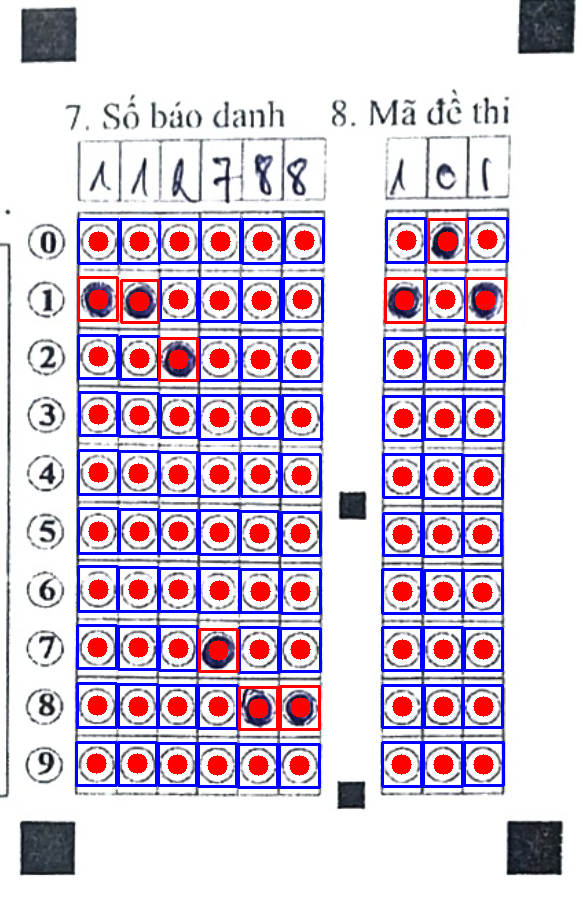

In [ ]:
cv2_imshow(info_part)

In [ ]:
list_boxes = []
for bbox, cls_id in zip(boxes, class_ids):
    list_boxes.append([bbox[0], bbox[1], cls_id])

list_boxes = np.array(list_boxes)
list_x = list_boxes[:, 0]
list_y = list_boxes[:, 1]

# Perform KMeans clustering
kmeans_x = KMeans(n_clusters=9, random_state=0).fit(list_x.reshape(-1, 1))
kmeans_y = KMeans(n_clusters=10, random_state=0).fit(list_y.reshape(-1, 1))

# Draw cluster centers on the image
for center_x in kmeans_x.cluster_centers_:
    for center_y in kmeans_y.cluster_centers_:
        cv2.circle(info_part, (int(center_x), int(center_y)), 10, (0, 0, 255), -1)

# Initialize result array
infor_result_array = np.ones((10, 9)) * -1

# Assign boxes to clusters
for box in list_boxes:
    new_point = box[:2]
    new_point_class_id = box[2]

    sorted_centers_x = np.sort(kmeans_x.cluster_centers_.flatten())
    sorted_centers_y = np.sort(kmeans_y.cluster_centers_.flatten())

    center_idx_x = np.argmin(np.abs(sorted_centers_x - new_point[0]))
    center_idx_y = np.argmin(np.abs(sorted_centers_y - new_point[1]))

    if new_point_class_id == 0:
        cv2.circle(info_part, (int(sorted_centers_x[center_idx_x]), int(sorted_centers_y[center_idx_y])), 10, (0, 255, 0), -1)
        infor_result_array[center_idx_y, center_idx_x] = 1
    else:
        cv2.circle(info_part, (int(sorted_centers_x[center_idx_x]), int(sorted_centers_y[center_idx_y])), 10, (255, 0, 0), -1)
        infor_result_array[center_idx_y, center_idx_x] = 0

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7e283d2531c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mod

In [ ]:
infor_result_array

array([[0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 1., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

## assignment

In [ ]:
image = cv2.imread("/content/drive/MyDrive/Thesis1/Done/khanh5.jpg")
image = cv2.resize(image, (2255, 3151))
assignment_part = image[middle_left[3]: bot_right[3], middle_left[2]:bot_right[0]]
cv2_imshow(assignment_part)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
CONFIDENCE_TRESHOLD = 0.1
result = assignment_model.predict(assignment_part, conf=CONFIDENCE_TRESHOLD, max_predictions=1000)
boxes = result.prediction.bboxes_xyxy
confidences = result.prediction.confidence
class_ids = result.prediction.labels.astype(int)
colors = [(0, 0, 255), (255, 0, 0)]
# for (bbox, cls_id) in zip(boxes, class_ids):
#     color = colors[cls_id]
#     cv2.rectangle(assignment_part, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 2)
#     center_x = int((bbox[0] + bbox[2]) / 2)
#     center_y = int((bbox[1] + bbox[3]) / 2)
#     cv2.circle(info_part, (center_x, center_y), 10, color, -1)

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[2024-07-02 01:46:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


In [ ]:
for (bbox, cls_id) in zip(boxes, class_ids):
    # color = colors[cls_id]
    # cv2.rectangle(assignment_part, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 2)
    center_x = int((bbox[0] + bbox[2]) / 2)
    center_y = int((bbox[1] + bbox[3]) / 2)
    cv2.circle(assignment_part, (center_x, center_y), 10, (0, 0, 255), -1)

In [ ]:
cv2_imshow(assignment_part)

Output hidden; open in https://colab.research.google.com to view.

### Lấy kết quả phần 1

In [ ]:
image = cv2.imread("/content/drive/MyDrive/Thesis1/Done/khanh5.jpg")

image = cv2.resize(image, (2255, 3151))
assignment_part = image[middle_left[3]: bot_right[3], middle_left[2]:bot_right[0]]
assignment_part_1 = assignment_part[0: top_2_left_multiple_choice_small[3]-middle_left[3], 0:bot_right[0]-middle_left[2]]

In [ ]:
CONFIDENCE_THRESHOLD = 0.7
result = assignment_model.predict(assignment_part_1, conf=CONFIDENCE_THRESHOLD, max_predictions=1000)
boxes = result.prediction.bboxes_xyxy
confidences = result.prediction.confidence
class_ids = result.prediction.labels.astype(int)
colors = [(0, 0, 255), (255, 0, 0)]

for (bbox, cls_id) in zip(boxes, class_ids):
    # color = colors[cls_id]
    # cv2.rectangle(assignment_part_1, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 2)
    center_x = int((bbox[0] + bbox[2]) / 2)
    center_y = int((bbox[1] + bbox[3]) / 2)
    cv2.circle(assignment_part_1, (center_x, center_y), 10, (0, 0, 255), -1)

[2024-07-02 01:46:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


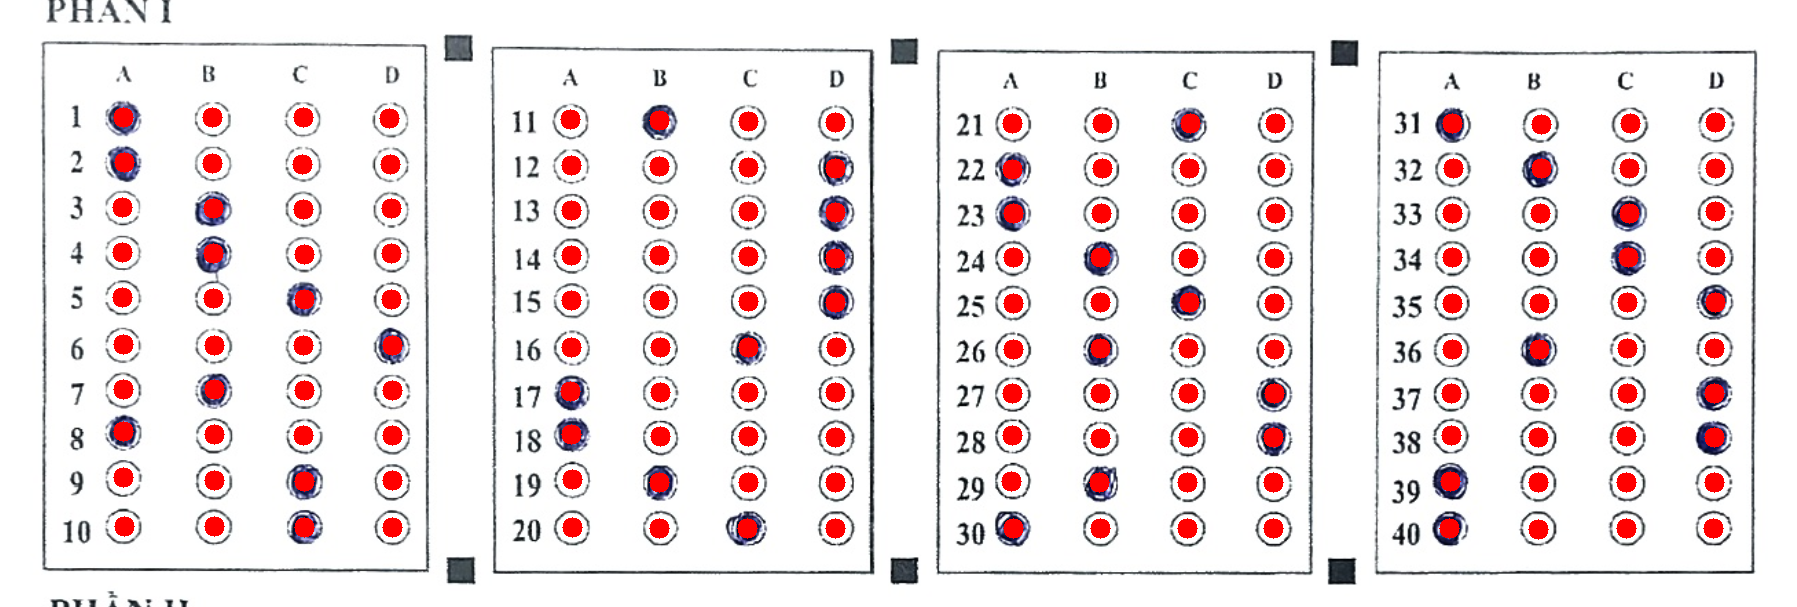

In [ ]:
cv2_imshow(assignment_part_1)

In [ ]:
list_boxes_assignment1 = []
for bbox, cls_id in zip(boxes, class_ids):
    list_boxes_assignment1.append([bbox[0], bbox[1], cls_id])

array_boxes_assignment1 = np.array(list_boxes_assignment1)
list_x = array_boxes_assignment1[:, 0]
list_y = array_boxes_assignment1[:, 1]

# Perform KMeans clustering
kmeans_x = KMeans(n_clusters=16, random_state=0).fit(list_x.reshape(-1, 1))
kmeans_y = KMeans(n_clusters=10, random_state=0).fit(list_y.reshape(-1, 1))

# Draw cluster centers on the image
for center_x in kmeans_x.cluster_centers_:
    for center_y in kmeans_y.cluster_centers_:
        cv2.circle(assignment_part_1, (int(center_x), int(center_y)), 10, (0, 0, 255), -1)

# Initialize result array
assignment1_result_array = np.ones((10, 16)) * -1

# Assign boxes to clusters
for box in array_boxes_assignment1:
    new_point = box[:2]
    new_point_class_id = box[2]

    sorted_centers_x = np.sort(kmeans_x.cluster_centers_.flatten())
    sorted_centers_y = np.sort(kmeans_y.cluster_centers_.flatten())

    center_idx_x = np.argmin(np.abs(sorted_centers_x - new_point[0]))
    center_idx_y = np.argmin(np.abs(sorted_centers_y - new_point[1]))

    if new_point_class_id == 0:
        cv2.circle(assignment_part_1, (int(sorted_centers_x[center_idx_x]), int(sorted_centers_y[center_idx_y])), 10, (0, 255, 0), -1)
        assignment1_result_array[center_idx_y, center_idx_x] = 1
    else:
        cv2.circle(assignment_part_1, (int(sorted_centers_x[center_idx_x]), int(sorted_centers_y[center_idx_y])), 10, (255, 0, 0), -1)
        assignment1_result_array[center_idx_y, center_idx_x] = 0

In [ ]:
assignment1_result_array

array([[1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.]])

### Lấy kết quả phần 2

In [ ]:
image = cv2.imread("/content/drive/MyDrive/Thesis1/Done/khanh5.jpg")

image = cv2.resize(image, (2255, 3151))
assignment_part = image[middle_left[3]: bot_right[3], middle_left[2]:bot_right[0]]
assignment_part_2 = assignment_part[top_3_left_multiple_choice_small[1]-middle_left[3]: top_4_left_multiple_choice_small[3]-middle_left[3], middle_left[2]-middle_left[2]:bot_right[0]-middle_left[2]]

In [ ]:
CONFIDENCE_THRESHOLD = 0.6
result = assignment_model.predict(assignment_part_2, conf=CONFIDENCE_THRESHOLD, max_predictions=1000)
boxes = result.prediction.bboxes_xyxy
confidences = result.prediction.confidence
class_ids = result.prediction.labels.astype(int)
colors = [(0, 0, 255), (255, 0, 0)]

for (bbox, cls_id) in zip(boxes, class_ids):
    # color = colors[cls_id]
    # cv2.rectangle(assignment_part_2, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 2)
    center_x = int((bbox[0] + bbox[2]) / 2)
    center_y = int((bbox[1] + bbox[3]) / 2)
    cv2.circle(assignment_part_2, (center_x, center_y), 10, (0, 0, 255), -1)

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[2024-07-02 01:47:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


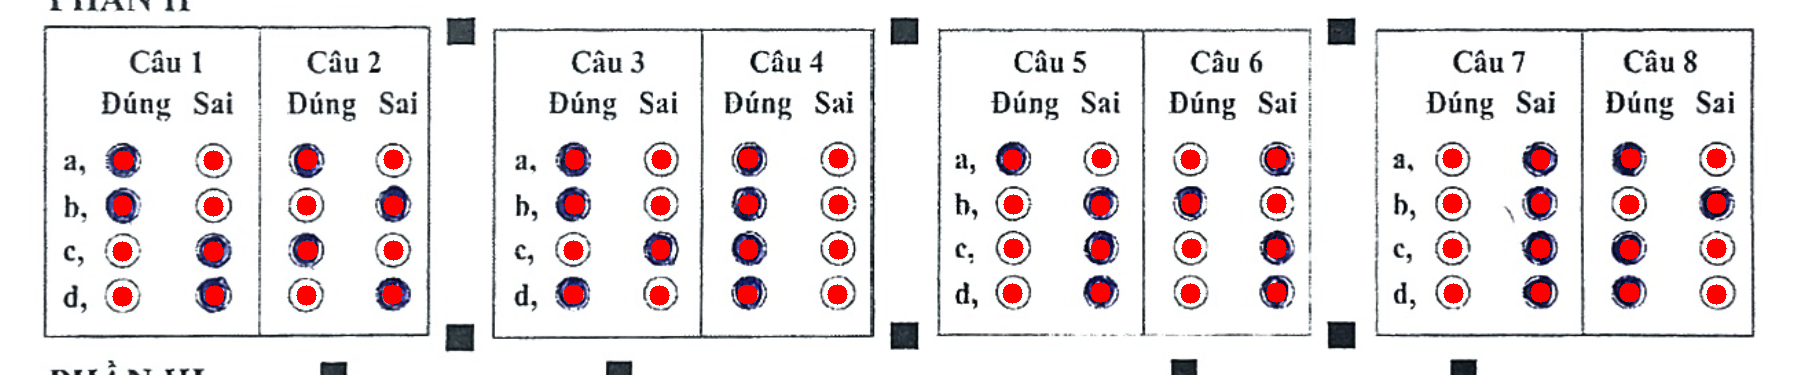

In [ ]:
cv2_imshow(assignment_part_2)

In [ ]:
list_boxes_assignment2 = []
for bbox, cls_id in zip(boxes, class_ids):
    list_boxes_assignment2.append([bbox[0], bbox[1], cls_id])

array_boxes_assignment2 = np.array(list_boxes_assignment2)
list_x = array_boxes_assignment2[:, 0]
list_y = array_boxes_assignment2[:, 1]

# Perform KMeans clustering
kmeans_x = KMeans(n_clusters=16, random_state=0).fit(list_x.reshape(-1, 1))
kmeans_y = KMeans(n_clusters=4, random_state=0).fit(list_y.reshape(-1, 1))

# Draw cluster centers on the image
for center_x in kmeans_x.cluster_centers_:
    for center_y in kmeans_y.cluster_centers_:
        cv2.circle(assignment_part_2, (int(center_x), int(center_y)), 10, (0, 0, 255), -1)

# Initialize result array
assignment2_result_array = np.ones((4, 16)) * -1

# Assign boxes to clusters
for box in array_boxes_assignment2:
    new_point = box[:2]
    new_point_class_id = box[2]

    sorted_centers_x = np.sort(kmeans_x.cluster_centers_.flatten())
    sorted_centers_y = np.sort(kmeans_y.cluster_centers_.flatten())

    center_idx_x = np.argmin(np.abs(sorted_centers_x - new_point[0]))
    center_idx_y = np.argmin(np.abs(sorted_centers_y - new_point[1]))

    if new_point_class_id == 0:
        cv2.circle(assignment_part_2, (int(sorted_centers_x[center_idx_x]), int(sorted_centers_y[center_idx_y])), 10, (0, 255, 0), -1)
        assignment2_result_array[center_idx_y, center_idx_x] = 1
    else:
        cv2.circle(assignment_part_2, (int(sorted_centers_x[center_idx_x]), int(sorted_centers_y[center_idx_y])), 10, (255, 0, 0), -1)
        assignment2_result_array[center_idx_y, center_idx_x] = 0

In [ ]:
assignment2_result_array

array([[1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0.],
       [1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1.],
       [0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.],
       [0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.]])

### Lấy kết quả phần 3

In [ ]:
image = cv2.imread("/content/drive/MyDrive/Thesis1/Done/khanh5.jpg")

image = cv2.resize(image, (2255, 3151))
assignment_part = image[middle_left[3]: bot_right[3], middle_left[2]:bot_right[0]]
assignment_part_3 = assignment_part[top_5_1_multiple_choice_small[1]-middle_left[3]: top_6_1_multiple_choice_small[3]-middle_left[3], middle_left[2]-middle_left[2]:bot_right[0]-middle_left[2]]

In [ ]:
CONFIDENCE_THRESHOLD = 0.6
result = assignment_model.predict(assignment_part_3, conf=CONFIDENCE_THRESHOLD, max_predictions=1000)
boxes = result.prediction.bboxes_xyxy
confidences = result.prediction.confidence
class_ids = result.prediction.labels.astype(int)
colors = [(0, 0, 255), (255, 0, 0)]

for (bbox, cls_id) in zip(boxes, class_ids):
    # color = colors[cls_id]
    # cv2.rectangle(assignment_part_3, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 2)
    center_x = int((bbox[0] + bbox[2]) / 2)
    center_y = int((bbox[1] + bbox[3]) / 2)
    cv2.circle(assignment_part_3, (center_x, center_y), 10, (0, 0, 255), -1)

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[2024-07-02 01:47:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


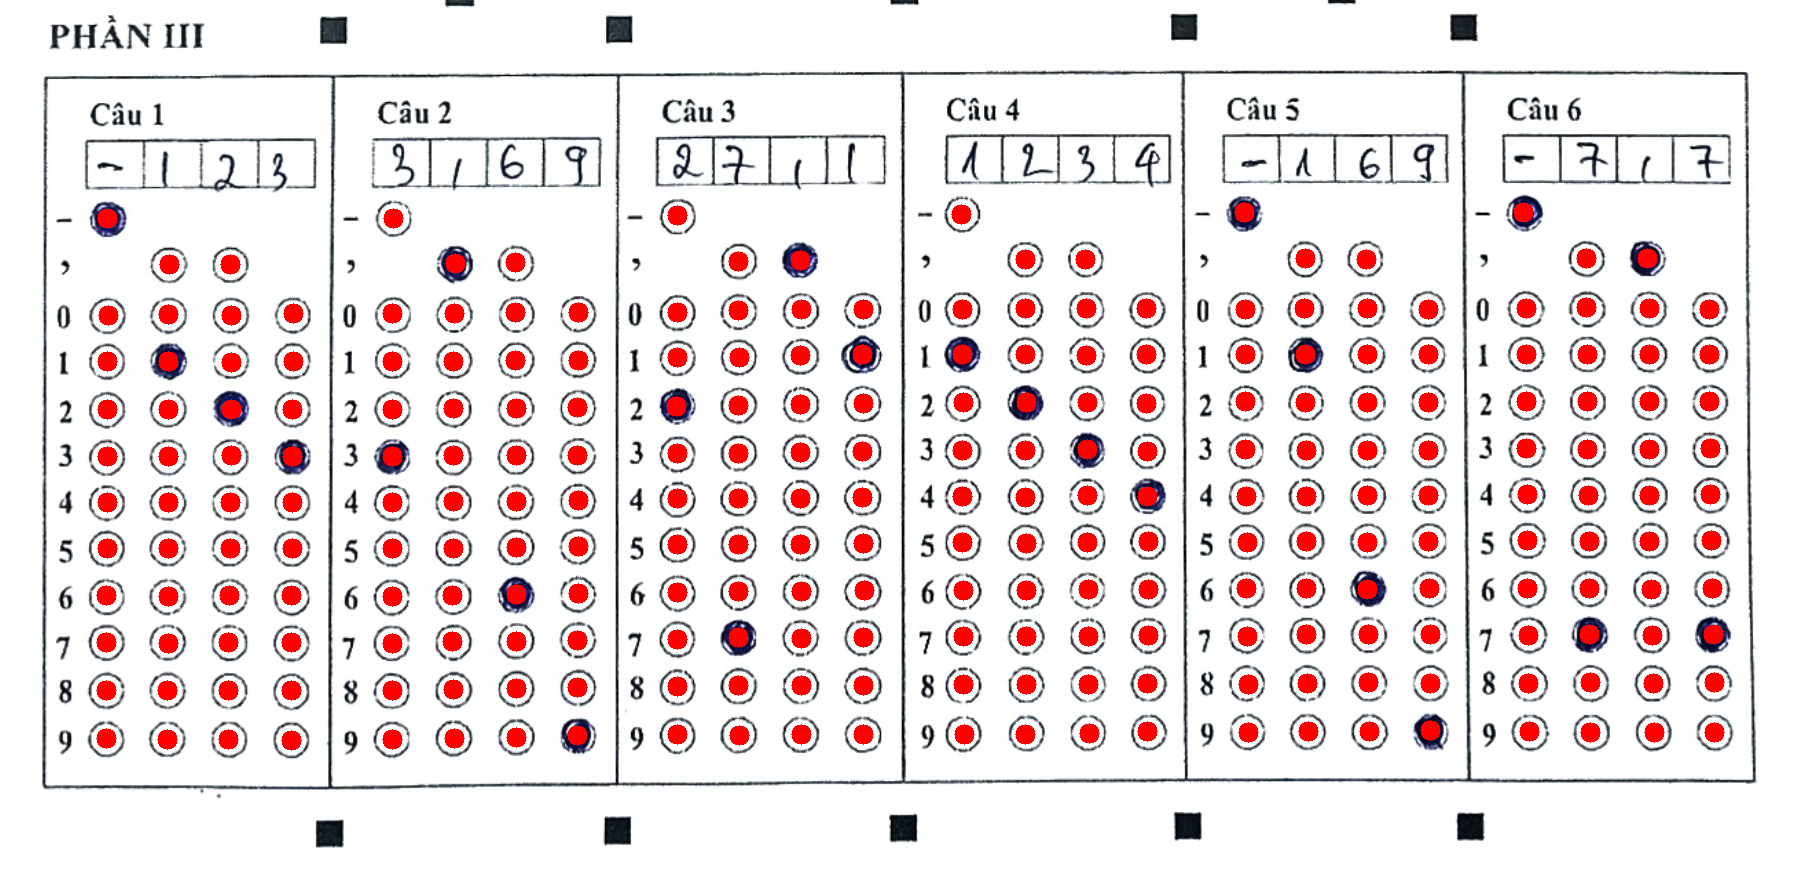

In [ ]:
cv2_imshow(assignment_part_3)

In [ ]:
list_boxes_assignment3 = []
for bbox, cls_id in zip(boxes, class_ids):
    list_boxes_assignment3.append([bbox[0], bbox[1], cls_id])

array_boxes_assignment3 = np.array(list_boxes_assignment3)
list_x = array_boxes_assignment3[:, 0]
list_y = array_boxes_assignment3[:, 1]

# Perform KMeans clustering
kmeans_x = KMeans(n_clusters=24, random_state=0).fit(list_x.reshape(-1, 1))
kmeans_y = KMeans(n_clusters=12, random_state=0).fit(list_y.reshape(-1, 1))

# Draw cluster centers on the image
for center_x in kmeans_x.cluster_centers_:
    for center_y in kmeans_y.cluster_centers_:
        cv2.circle(assignment_part_3, (int(center_x), int(center_y)), 10, (0, 0, 255), -1)

# Initialize result array
assignment3_result_array = np.ones((12, 24)) * -1

# Assign boxes to clusters
for box in array_boxes_assignment3:
    new_point = box[:2]
    new_point_class_id = box[2]

    sorted_centers_x = np.sort(kmeans_x.cluster_centers_.flatten())
    sorted_centers_y = np.sort(kmeans_y.cluster_centers_.flatten())

    center_idx_x = np.argmin(np.abs(sorted_centers_x - new_point[0]))
    center_idx_y = np.argmin(np.abs(sorted_centers_y - new_point[1]))

    if new_point_class_id == 0:
        cv2.circle(assignment_part_3, (int(sorted_centers_x[center_idx_x]), int(sorted_centers_y[center_idx_y])), 10, (0, 255, 0), -1)
        assignment3_result_array[center_idx_y, center_idx_x] = 1
    else:
        cv2.circle(assignment_part_3, (int(sorted_centers_x[center_idx_x]), int(sorted_centers_y[center_idx_y])), 10, (255, 0, 0), -1)
        assignment3_result_array[center_idx_y, center_idx_x] = 0

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-67-13e576470b57>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cv2.circle(assignment_part_3, (int(center_x), int(center_y)), 10, (0, 0, 255), -1)


In [ ]:
assignment3_result_array

array([[ 1., -1., -1., -1.,  0., -1., -1., -1.,  0., -1., -1., -1.,  0.,
        -1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1., -1.],
       [-1.,  0.,  0., -1., -1.,  1.,  0., -1., -1.,  0.,  1., -1., -1.,
         0.,  0., -1., -1.,  0.,  0., -1., -1.,  0.,  1., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.

# Đối chiếu và chấm điểm

## info

In [ ]:
import numpy as np
matrix = infor_result_array

# Tìm các vị trí khác 0 theo cột
non_zero_positions = {}
flag = [True, True, True, True, True, True, True, True, True]
# Duyệt qua từng cột
for col in range(matrix.shape[1]):
    # Tìm các hàng có giá trị khác 0 trong cột hiện tại
    rows_with_non_zero = np.where(matrix[:,col] != 0)[0]
    print(rows_with_non_zero)
    # Lưu lại kết quả
    count = 0
    if len(rows_with_non_zero) > 0:
        non_zero_positions[col] = rows_with_non_zero.tolist()
        print(non_zero_positions)
        if len(rows_with_non_zero.tolist()) != 1:
            flag[col] = False

if len(non_zero_positions) == 0:
    SBD = ""
    Ma_De_Thi = ""
else:
    if False not in flag:
        SBD = ""
        Ma_De_Thi = ""
        for i in range(6):
          # Check if key exists in dictionary
            if i in non_zero_positions:
                SBD += str(non_zero_positions[i][0])

        for i in range(6, 9):
          # Check if key exists in dictionary
            if i in non_zero_positions:
                Ma_De_Thi += str(non_zero_positions[i][0])

print("SBD:", SBD)
print("Mã đề thi:", Ma_De_Thi)

[1]
{0: [1]}
[1]
{0: [1], 1: [1]}
[2]
{0: [1], 1: [1], 2: [2]}
[7]
{0: [1], 1: [1], 2: [2], 3: [7]}
[8]
{0: [1], 1: [1], 2: [2], 3: [7], 4: [8]}
[8]
{0: [1], 1: [1], 2: [2], 3: [7], 4: [8], 5: [8]}
[1]
{0: [1], 1: [1], 2: [2], 3: [7], 4: [8], 5: [8], 6: [1]}
[0]
{0: [1], 1: [1], 2: [2], 3: [7], 4: [8], 5: [8], 6: [1], 7: [0]}
[1]
{0: [1], 1: [1], 2: [2], 3: [7], 4: [8], 5: [8], 6: [1], 7: [0], 8: [1]}
SBD: 112788
Mã đề thi: 101


## Chấm điểm

### Phần 1

In [ ]:
import numpy as np
import collections
matrix = assignment1_result_array
number_question = 40
number_choice_per_question = 4
number_row = 10
answer_id_part_1 = np.zeros((number_question,))

for i in range(number_question):
  col = i // number_row
  row = i % number_row
  check_matrix = matrix[row, col*number_choice_per_question:col*number_choice_per_question+number_choice_per_question]
  print(check_matrix)
  check_count = collections.Counter(check_matrix)
  print(check_count)
  print(check_count[-1])
  print(check_count[1])

[1. 0. 0. 0.]
Counter({0.0: 3, 1.0: 1})
0
1
[1. 0. 0. 0.]
Counter({0.0: 3, 1.0: 1})
0
1
[0. 1. 0. 0.]
Counter({0.0: 3, 1.0: 1})
0
1
[0. 1. 0. 0.]
Counter({0.0: 3, 1.0: 1})
0
1
[0. 0. 1. 0.]
Counter({0.0: 3, 1.0: 1})
0
1
[0. 0. 0. 1.]
Counter({0.0: 3, 1.0: 1})
0
1
[0. 1. 0. 0.]
Counter({0.0: 3, 1.0: 1})
0
1
[1. 0. 0. 0.]
Counter({0.0: 3, 1.0: 1})
0
1
[0. 0. 1. 0.]
Counter({0.0: 3, 1.0: 1})
0
1
[0. 0. 1. 0.]
Counter({0.0: 3, 1.0: 1})
0
1
[0. 1. 0. 0.]
Counter({0.0: 3, 1.0: 1})
0
1
[0. 0. 0. 1.]
Counter({0.0: 3, 1.0: 1})
0
1
[0. 0. 0. 1.]
Counter({0.0: 3, 1.0: 1})
0
1
[0. 0. 0. 1.]
Counter({0.0: 3, 1.0: 1})
0
1
[0. 0. 0. 1.]
Counter({0.0: 3, 1.0: 1})
0
1
[0. 0. 1. 0.]
Counter({0.0: 3, 1.0: 1})
0
1
[1. 0. 0. 0.]
Counter({0.0: 3, 1.0: 1})
0
1
[1. 0. 0. 0.]
Counter({0.0: 3, 1.0: 1})
0
1
[0. 1. 0. 0.]
Counter({0.0: 3, 1.0: 1})
0
1
[0. 0. 1. 0.]
Counter({0.0: 3, 1.0: 1})
0
1
[0. 0. 1. 0.]
Counter({0.0: 3, 1.0: 1})
0
1
[1. 0. 0. 0.]
Counter({0.0: 3, 1.0: 1})
0
1
[1. 0. 0. 0.]
Counter({0.0: 3, 1

In [ ]:
import numpy as np
import collections
matrix = assignment1_result_array
number_question = 40
number_choice_per_question = 4
number_row = 10
answer_id_part_1 = np.zeros((number_question,))

for i in range(number_question):
  col = i // number_row
  row = i % number_row
  check_matrix = matrix[row, col*number_choice_per_question:col*number_choice_per_question+number_choice_per_question]
  check_count = collections.Counter(check_matrix)

  if check_count[-1] != 0 or check_count[1] > 1:
    # flag[i] = False
    answer_id_part_1[i] = 5
  else:
    max_index = np.argmax(check_matrix)
    max_value = np.max(check_matrix)
    if int(max_value) == 1:
      answer_id_part_1[i] = max_index
    else:
      answer_id_part_1[i] = 4

# Map 0 -> A, 1-> B, 2 -> C, 3 -> D
true_answer_part_1 = []
map_dict = {0: 'A', 1: 'B', 2: "C", 3: "D", 4: "Chưa chọn", 5: "Chọn quá nhiều"}
answer = ""
for i in range(number_question):
  true_answer_part_1.append(map_dict[int(answer_id_part_1[i])])

print(true_answer_part_1)

['A', 'A', 'B', 'B', 'C', 'D', 'B', 'A', 'C', 'C', 'B', 'D', 'D', 'D', 'D', 'C', 'A', 'A', 'B', 'C', 'C', 'A', 'A', 'B', 'C', 'B', 'D', 'D', 'B', 'A', 'A', 'B', 'C', 'C', 'D', 'B', 'D', 'D', 'A', 'A']


### Phần 2

In [ ]:
import numpy as np
import collections

matrix = assignment2_result_array

# Tìm các vị trí khác 0 theo cột
# non_zero_positions = {}

number_question = 32
number_choice_per_question = 2
number_row = 4
# flag = [True for i in range(number_question)]
answer_id_part_2 = np.zeros((number_question,))

for i in range(number_question):
  col = i // number_row
  row = i % number_row
  check_matrix = matrix[row, col*number_choice_per_question:col*number_choice_per_question+number_choice_per_question]
  check_count = collections.Counter(check_matrix)

  if check_count[-1] != 0 or check_count[1] > 1:
    # flag[i] = False
    answer_id_part_2[i] = 3
  else:
    max_index = np.argmax(check_matrix)
    max_value = np.max(check_matrix)
    if int(max_value) == 1:
      answer_id_part_2[i] = max_index
    else:
      answer_id_part_2[i] = 2

# Map 0 -> A, 1-> B, 2 -> C, 3 -> D
true_answer_part_2 = []
map_dict = {0: 'Đúng', 1: 'Sai', 2: "Chưa chọn", 3: "Chọn quá nhiều"}
answer = ""
for i in range(number_question):
  true_answer_part_2.append(map_dict[int(answer_id_part_2[i])])

true_answer_part_2

['Đúng',
 'Đúng',
 'Sai',
 'Sai',
 'Đúng',
 'Sai',
 'Đúng',
 'Sai',
 'Đúng',
 'Đúng',
 'Sai',
 'Đúng',
 'Đúng',
 'Đúng',
 'Đúng',
 'Đúng',
 'Đúng',
 'Sai',
 'Sai',
 'Sai',
 'Sai',
 'Đúng',
 'Sai',
 'Sai',
 'Sai',
 'Sai',
 'Sai',
 'Sai',
 'Đúng',
 'Sai',
 'Đúng',
 'Đúng']

### Phần 3

In [ ]:
import numpy as np

matrix = assignment3_result_array

# Tìm các vị trí khác 0 theo cột
non_zero_positions = []

flag = [True for i in range(matrix.shape[1])]

# Duyệt qua từng cột
for col in range(matrix.shape[1]):
    # Tìm các hàng có giá trị khác 0 trong cột hiện tại
    rows_with_non_zero = np.where(matrix[:, col] == 1)[0]
    # Lưu lại kết quả, kiểm tra xem có phần tử nào trong danh sách không trước khi lấy [0]
    if rows_with_non_zero.size != 1:
      non_zero_positions.append(12)
    else:
      non_zero_positions.append(rows_with_non_zero[0])

# Map 0 -> A, 1-> B, 2 -> C, 3 -> D
true_answer = []
map_dict = {0: '-', 1: ',', 2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8, 11: 9, 12: 'Chưa chọn', 13: 'Chọn quá nhiều'}

for i in range(len(non_zero_positions)):
    true_answer.append(map_dict[int(non_zero_positions[i])])

true_answer_part_3 = []
answer_id_part_3 = []
for i in range(6):
    answer_number = ""
    answer_id = []
    for j in range(i * 4, (i + 1) * 4):
        answer_number += str(true_answer[j])
        answer_id.append(int(non_zero_positions[j]))
    answer_id_part_3.append(answer_id)
    true_answer_part_3.append(answer_number)

print(answer_id_part_3)

## Tổng hợp đáp án

In [ ]:
print(true_answer_part_1)
print(true_answer_part_2)
print(true_answer_part_3)
print(answer_id_part_1)
print(answer_id_part_2)
print(answer_id_part_3)

['A', 'A', 'B', 'B', 'C', 'D', 'B', 'A', 'C', 'C', 'B', 'D', 'D', 'D', 'D', 'C', 'A', 'A', 'B', 'C', 'C', 'A', 'A', 'B', 'C', 'B', 'D', 'D', 'B', 'A', 'A', 'B', 'C', 'C', 'D', 'B', 'D', 'D', 'A', 'A']
['Đúng', 'Đúng', 'Sai', 'Sai', 'Đúng', 'Sai', 'Đúng', 'Sai', 'Đúng', 'Đúng', 'Sai', 'Đúng', 'Đúng', 'Đúng', 'Đúng', 'Đúng', 'Đúng', 'Sai', 'Sai', 'Sai', 'Sai', 'Đúng', 'Sai', 'Sai', 'Sai', 'Sai', 'Sai', 'Sai', 'Đúng', 'Sai', 'Đúng', 'Đúng']
['-123', '3,69', '27,1', '1234', '-169', '-7,7']
[0. 0. 1. 1. 2. 3. 1. 0. 2. 2. 1. 3. 3. 3. 3. 2. 0. 0. 1. 2. 2. 0. 0. 1.
 2. 1. 3. 3. 1. 0. 0. 1. 2. 2. 3. 1. 3. 3. 0. 0.]
[0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 0. 1. 0. 0.]
[[0, 3, 4, 5], [5, 1, 8, 11], [4, 9, 1, 3], [3, 4, 5, 6], [0, 3, 8, 11], [0, 9, 1, 9]]


In [ ]:
import pandas as pd
data_part_1 = pd.DataFrame(answer_id_part_1, columns=["answer_id"], dtype=int)
data_part_1["part"] = 1
data_part_1["question_id"] = list(range(1, 41))
data_part_2 = pd.DataFrame(answer_id_part_2, columns=["answer_id"], dtype= int)
data_part_2["part"] = 2
data_part_2["question_id"] = list(range(1, 33))
data_part_3 = pd.DataFrame({"answer_id": answer_id_part_3})
data_part_3["part"] = 3
data_part_3["question_id"] = list(range(1, 7))

check_data = pd.concat([data_part_1, data_part_2, data_part_3])

# Arrange columns = [part, question_id, answer_id]
check_data = check_data[["part", "question_id", "answer_id"]]
check_data

part  question_id      answer_id
0      1            1              0
1      1            2              0
2      1            3              1
3      1            4              1
4      1            5              2
..   ...          ...            ...
1      3            2  [5, 1, 8, 11]
2      3            3   [4, 9, 1, 3]
3      3            4   [3, 4, 5, 6]
4      3            5  [0, 3, 8, 11]
5      3            6   [0, 9, 1, 9]

[78 rows x 3 columns]

## Load file đáp án và chấm điểm

In [ ]:
# import csv
# import random

# data = []
# for i in range(1, 41):  # 40 câu part 1
#     data.append([1, i, random.randint(0, 3)])
# for i in range(1, 33):  # 32 câu part 2
#     data.append([2, i, random.randint(0, 3)])
# for i in range(1, 7):  # 6 câu part 3
#     data.append([3, i, sorted(random.sample(range(12), 4))])

# with open('example_result.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(["part", "question_id", "answer_id"])
#     writer.writerows(data)

In [ ]:
import pandas as pd

true_data = pd.read_csv("/content/drive/MyDrive/Thesis1/Done/example_result.csv")
true_data = true_data.rename(columns={"answer_id": "true_answer"})
true_data

part  question_id     true_answer
0      1            1               0
1      1            2               0
2      1            3               1
3      1            4               1
4      1            5               2
..   ...          ...             ...
73     3            2   [4, 6, 8, 11]
74     3            3    [2, 5, 7, 8]
75     3            4    [0, 1, 2, 6]
76     3            5  [3, 8, 10, 11]
77     3            6  [7, 9, 10, 11]

[78 rows x 3 columns]

In [ ]:
score_1 = 0
score_2 = 0
score_3 = 0
for i in range(len(true_data)):
  if int(true_data.iloc[i]["part"]) == 1:
    if int(true_data.iloc[i]["true_answer"]) == int(check_data.iloc[i]["answer_id"]):
      score_1 += 1
  elif int(true_data.iloc[i]["part"]) == 3:
    flag = True
    true_string = true_data.iloc[i]["true_answer"]
    # Loại bỏ "[" và "]"
    true_string = true_string.replace("[", "")
    true_string = true_string.replace("]", "")
    true_array = [int(x) for x in true_string.split(",")]
    for j in range(4):
      if int(true_array[j]) == int(check_data.iloc[i]["answer_id"][j]):
        flag = False
    if flag:
      score_3 += 1

all_answer_question_2 = true_data[true_data["part"] == 2]
for i in range(8):
  score_check = 0
  for j in range(i*4, (i+1)*4):
    if int(true_data.iloc[j]["true_answer"]) == int(all_answer_question_2.iloc[j]["true_answer"]):
      score_check += 1
  if score_check == 4:
    score_2 += 1

In [ ]:
MAX_PART_1 = 40
MAX_PART_2 = 8
MAX_PART_3 = 6
WEIGHT_PART_1 = 3
WEIGHT_PART_2 = 3
WEIGHT_PART_3 = 4

true_score = score_1 / MAX_PART_1 * WEIGHT_PART_1 + score_2 / MAX_PART_2 * WEIGHT_PART_2 + score_3 / MAX_PART_3 * WEIGHT_PART_3


print("Số câu chọn đúngg ở phần 1:", score_1)
print("Số câu chọn đúng ở phần 2:", score_2)
print("Số câu chọn đúng ở phần 3:", score_3)
print("Điểm kiểm tra của sinh viên", round(true_score, 2))

Số câu chọn đúngg ở phần 1: 17
Số câu chọn đúng ở phần 2: 0
Số câu chọn đúng ở phần 3: 2
Điểm kiểm tra của sinh viên 2.61


End.